# Fed vs. fasted: comparing RSNs in giant Mappers

Let's recreate Figure 4 in Poldrack et al. 2015, Nature Communications, using Mapper!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

In [3]:
%matplotlib inline

## Load data

In [4]:
sessions = load_scrubbed(n_sessions=10,  merge=True,#False,
    apply_tmask=True,
    apply_rmask=True, rmask_kwds=dict(n=5, minor=False),
    zscore=False
    )

INFO:load_data:load_scrubbed(**{'n_sessions': 10, 'merge': True, 'apply_tmask': True, 'apply_rmask': True, 'rmask_kwds': {'n': 5, 'minor': False}, 'zscore': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 0, file: sub014.txt
INFO:root:      keeping: 505 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 1, file: sub015.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 2, file: sub016.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 3, file: sub017.txt
INFO:root:      keeping: 504 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 4, file: sub018.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 5, file: sub019.txt
INFO:root:      keeping: 513 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 6, file: sub020.t

### Clean data

Load temporal masks and remove TRs with excessive motion. Additionally, remove parcels that do not belong to major RSNs.

In [5]:
splits = get_data_splits(sessions, zscore=True, groupby='day_of_week', groups={2:'fast', 4:'fed'}, density=0.05)

print('splits: ', splits.keys())

            1.0 => day_of_week_0    x.shape: (1517, 437)  RSN.shape: (1517, 5)
            2.0 => fast             x.shape: (1532, 437)  RSN.shape: (1532, 5)
            4.0 => fed              x.shape: (1856, 437)  RSN.shape: (1856, 5)
splits:  dict_keys(['day_of_week_0', 'fast', 'fed'])


## Generate $MAPPER$ graphs

### Start local server for visualization

In [6]:
%%bash --bg

python3 -m http.server 8800

Starting job # 0 in a separate thread.


### Run Mapper in temporal space - create one super graph for both fed and fasted

#### (split = fed)

In [7]:
# Run Mapper/DyNeuSR
print('Running mapper on fed data...')
try:
    splits.fed.lens = results_fed.get('lens')
    print('*** Found lens... (set lens=None to re-run)')
except:
    splits.fed.lens = None
results_fed = run_mapper(splits.fed.X, splits.fed.RSN, lens=splits.fed.lens, verbose=1, cover=km.Cover(20,0.8))

Running mapper on fed data...
KeplerMapper()
Mapping on data shaped (1856, 437) using lens shaped (1856, 2)

Creating 400 hypercubes.

Created 615 edges and 288 nodes in 0:00:00.625640.


label,group,value,row_count
Cingulo_opercular,0,93,1855
Frontoparietal_1,1,93,1855
Somatomotor,2,93,1855
Visual_2,3,93,1855
DMN,4,93,1855


In [8]:
# Visualize DyNeuGraph
results_fed['dG'].visualize(path_html='results/fed_super_n=10.html', show=True, PORT=8800)

[Force Graph] http://localhost:8800/results/fed_super_n=10.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

##### Quick look (png)

![fed_super](./results/png/fed_super_n=10.png)

#### (split = fasted)

In [9]:
# Run Mapper/DyNeuSR
print('Running mapper on fasted data...')
try:
    splits.fast.lens = results_fast.get('lens')
    print('*** Found lens... (set lens=None to re-run)')
except:
    splits.fast.lens = None
results_fast = run_mapper(splits.fast.X, splits.fast.RSN, lens=splits.fast.lens, verbose=1, cover=km.Cover(20,0.8))

Running mapper on fasted data...
KeplerMapper()
Mapping on data shaped (1532, 437) using lens shaped (1532, 2)

Creating 400 hypercubes.

Created 535 edges and 301 nodes in 0:00:00.503966.


label,group,value,row_count
Cingulo_opercular,0,77,1531
Frontoparietal_1,1,77,1531
Somatomotor,2,76,1531
Visual_2,3,77,1531
DMN,4,77,1531


In [10]:
# Visualize DyNeuGraph
results_fast['dG'].visualize(path_html='results/fast_super_n=10.html', show=True, PORT=8800)

[Force Graph] http://localhost:8800/results/fast_super_n=10.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

##### Quick look (png)


![fast_super](./results/png/fast_super_n=10.png)

### Check TCMs

In [15]:
import bct 

def visualize_metric(W=None, c=None, metric=bct.module_degree_zscore, cmap='plasma'):
    """ Evaluate metric and plot scores
    
    
    """
    print('[visualize_metric] metric: ', metric)
    metric_func = metric if callable(metric) else getattr(bct, metric)
    
    # copy other inputs
    coloring_ = c.copy()

    # loop through columns in c
    scores = dict()
    for column in coloring_.columns:
        ci = coloring_[column].values
        try:
            ci = ci.astype(float)
        except Exception as e:
            continue
        print('                   scoring:', column, ci.shape)
        
        # evaluate
        zi = metric_func(W, ci)
        scores[column] = Bunch(ci=ci.copy(), zi=zi.copy())
        
        # plot
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        # TCM + ci
        sns.heatmap(W*ci + (W*ci).T, ax=axes[0], square=True,  cbar=False, xticklabels=500, yticklabels=500, cmap=cmap)   
        sns.heatmap(np.zeros_like(W) + ci.reshape(-1, 1), xticklabels=False,yticklabels=500,  square=True, cbar=False,  ax=axes[1], cmap=cmap)    
        # TCM
        sns.heatmap(W, ax=axes[2],   square=True, cbar=False, xticklabels=500, yticklabels=500, cmap=cmap)      
        axes[2].set_title(column, fontweight='bold')
        # TCM + zi
        sns.heatmap(np.zeros_like(W) + zi.reshape(-1, 1), xticklabels=False,yticklabels=500,  square=True, cbar=False,  ax=axes[3], cmap=cmap)  
        sns.heatmap(W*zi + (W*zi).T, ax=axes[4], square=True, cbar=False, xticklabels=500, yticklabels=500, cmap=cmap) 
        
        # show
        plt.show()
        
    return scores


### Evaluate graph metrics

In [ ]:
scores = Bunch()

#### Metrics (RSN)

In [16]:
TCM = results_fed.TCM.copy()
coloring = splits.fed.RSN.copy()
scores.RSN = Bunch()

[visualize_metric] metric:  <function module_degree_zscore at 0x118a1dbf8>
                   scoring: Cingulo_opercular (1856,)


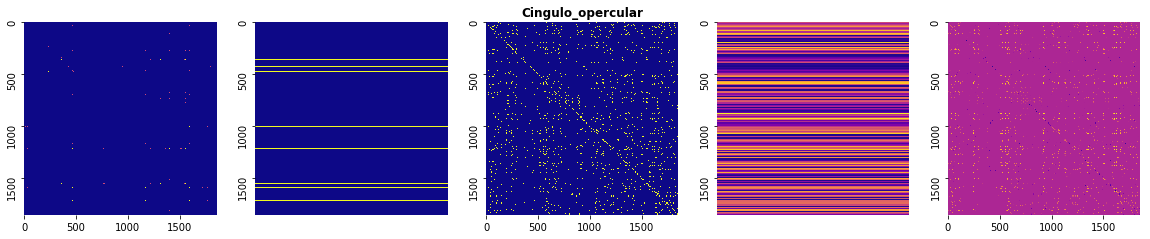

                   scoring: Frontoparietal_1 (1856,)


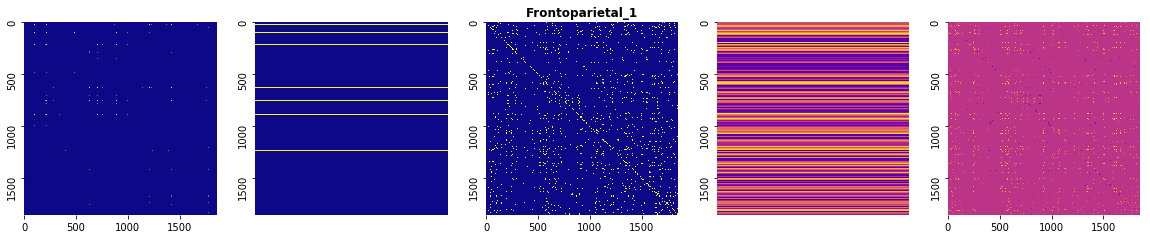

                   scoring: Somatomotor (1856,)


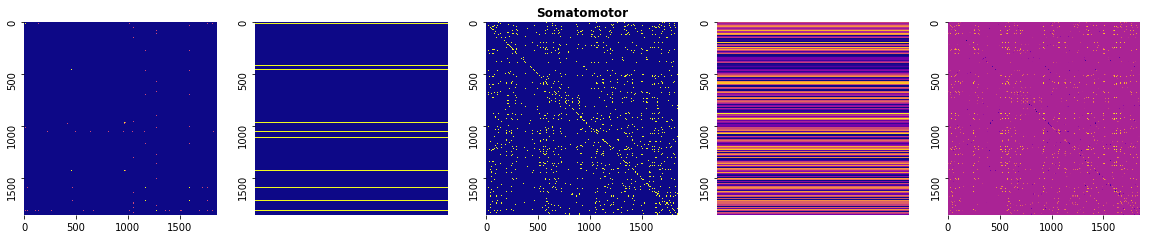

                   scoring: Visual_2 (1856,)


In [ ]:
scores.RSN.modz = visualize_metric(W=TCM, c=coloring, metric=bct.module_degree_zscore)

In [ ]:
scores.RSN.pcoef = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef)

In [ ]:
scores.RSN.pcoef_s = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef_sign)

#### Metrics (meta)

In [ ]:
TCM = results_fed.TCM.copy()
coloring = splits.fed.meta.copy()
columns = coloring[[_ for _ in coloring.columns if 'panas:' in _ or _ in ('session_id', 'tr_id')]]
scores.meta = Bunch()

In [ ]:
scores.meta.modz = visualize_metric(W=TCM, c=coloring, metric=bct.module_degree_zscore)

In [ ]:
scores.meta.pcoef = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef)

In [ ]:
scores.meta.pcoef_s = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef_sign)

#### old

### Run Mapper in anatomical space - create one super graph for both fed and fasted